In [1]:
import random
import math
import numpy as np
import Parsing_midi as pm
import Init_chromo as init
import Melody_matching as mm
import count_CE as ce
import mido
from mido import Message, MidiFile, MidiTrack
from collections import Counter
import copy
import matplotlib.pyplot as plt
from itertools import combinations # product: 排列
import time
import multiprocessing as mp
import pretty_midi

/home/hsuan/env1/lib/python3.6/site-packages/pydub/utils.py:165: RuntimeWarning: Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work
  warn("Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work", RuntimeWarning)


### Seperate phrase
- one bar = 1920 (4 beats)
- sliding window = 7680 (4 bar)

In [2]:
midi_list = pm.get_midi('star.mid', 0)

In [8]:
tt = pm.get_midi('Output_midi/sky_55.3_70.mid', 0)
tt

[<message note_on channel=0 note=72 velocity=72 time=960>,
 <message note_on channel=0 note=72 velocity=0 time=455>,
 <message note_on channel=0 note=72 velocity=85 time=25>,
 <message note_on channel=0 note=72 velocity=0 time=455>,
 <message note_on channel=0 note=79 velocity=76 time=25>,
 <message note_on channel=0 note=79 velocity=0 time=455>,
 <message note_on channel=0 note=79 velocity=68 time=25>,
 <message note_on channel=0 note=79 velocity=0 time=455>,
 <message note_on channel=0 note=81 velocity=80 time=25>,
 <message note_on channel=0 note=81 velocity=0 time=455>,
 <message note_on channel=0 note=81 velocity=89 time=25>,
 <message note_on channel=0 note=81 velocity=0 time=455>,
 <message note_on channel=0 note=79 velocity=85 time=25>,
 <message note_on channel=0 note=79 velocity=0 time=455>,
 <message note_on channel=0 note=79 velocity=85 time=25>,
 <message note_on channel=0 note=79 velocity=0 time=455>,
 <message note_on channel=0 note=77 velocity=85 time=25>,
 <message not

In [ ]:
note_msg, midi_msg = pm.separate_song(tt, 11520)
pm.to_midi_file(midi_msg[0], 1 , 'star.mid')

# origin_note = [trans_note_list(midi_msg[i]) for i in range(len(midi_msg))]

In [ ]:
print(pm.get_piano_roll())

In [ ]:
import librosa.display

def plot_piano_roll(pm, start_pitch, end_pitch, fs=100):
    # Use librosa's specshow function for displaying the piano roll
    librosa.display.specshow(pm.get_piano_roll(fs)[start_pitch:end_pitch],
                             hop_length=1, sr=fs, x_axis='time', y_axis='cqt_note',
                             fmin=pretty_midi.note_number_to_hz(start_pitch))
    
pm = pretty_midi.PrettyMIDI('Output_midi/sky_75.55_33.mid')
plt.figure(figsize=(12, 4))
plot_piano_roll(pm, 24, 84)

pm2 = pretty_midi.PrettyMIDI('Output_midi/sky_73.5_1.mid')
plt.figure(figsize=(12, 4))
plot_piano_roll(pm2, 24, 84)

In [ ]:
star2 = pretty_midi.PrettyMIDI('star2.mid')
plt.figure(figsize=(12, 4))
plot_piano_roll(star2, 24, 84)

star = pretty_midi.PrettyMIDI('star.mid')
plt.figure(figsize=(12, 4))
plot_piano_roll(star, 24, 84)

In [3]:
def trans_note_list(song):
    return [song[i].note for i in range(len(song))]

note_msg, midi_msg = pm.separate_song(midi_list, 9600)
parent = midi_msg[0]  # can change here for testing

def flatten_list(midi_list):
    return [item for sublist in midi_list for item in sublist]

In [ ]:
## transform to C major (-3)
for i in range(len(parent)):
    parent[i].note = parent[i].note -3 # shift    
pm.to_midi_file(parent, 8 , 'ori.mid')

In [4]:
## 4 beats (1920) in one bar
note_msg, midi_msg = pm.separate_song(parent, 1920)
origin_note = [trans_note_list(midi_msg[i]) for i in range(len(midi_msg))]

### Evolutionary algorithmn
- selection
- crossover
- mutation
- fitness

In [5]:
CE = ce.get_ce_list(midi_msg)  # CE list from every bar

## Selection
def get_fitness_score(new_midi):
    score = 0
    global temp
    # melody matching
    ori = flatten_list(midi_msg)
    new = flatten_list(new_midi)
    smooth_area_score = mm.count_area_score(ori, new, smooth_curve=True)  # smooth
    area_score = mm.count_area_score(ori, new, smooth_curve=False)  
    for i in range(len(CE)): # 分小節計算分數
        ## encoding
        try:
            temp = copy.deepcopy(new_midi) # 整個midi       
            note = trans_note_list(temp[i])# 取出一小節  # TODO可能超過原本的小結數
            _score, mid = fitness(temp[i], note, CE[i], origin_note[i]) # score per bar
            score += _score
        except:
            pass
    return score + area_score + smooth_area_score

def select_best(pop_list):  # used in initialization
    pop_idx = [i for i in range(len(pop_list))]
    score = -10000; pop1 = []; pop2 = []
    candidate = list(combinations(pop_idx, 2))
    for i in range(len(candidate)):
        individual1, individual2 = pop_list[candidate[i][0]], pop_list[candidate[i][1]]
        ind_note1, ind_midi1 = pm.separate_song(individual1, 1920) 
        ind_note2, ind_midi2 = pm.separate_song(individual2, 1920) 

        score1 = get_fitness_score(ind_midi1)  # several bars
        score2 = get_fitness_score(ind_midi2)

        total_score = score1 + score2
        if score < total_score :
            score = total_score
            pop1, pop2 = ind_midi1, ind_midi2
    return pop1, pop2, score

## Crossover
def crossover(parent, pop):
    ind1 = copy.deepcopy(parent)
    ind2 = copy.deepcopy(pop)   
    if len(ind1)<len(ind2):
        ind2 = ind2[:len(ind1)]
    else:
        ind1 = ind1[:len(ind2)]
        
    crossover_point = random.randint(0,len(ind1)-2)
 #     ind1[crossover_point].note != ind1[crossover_point-1].note or 
       
    while crossover_point % 2 != 0:
        crossover_point = random.randint(1,len(ind1)-2)
    if ind2[crossover_point].note != ind2[crossover_point-1].note and \
    ind1[crossover_point].note != ind1[crossover_point-1].note and \
    ind2[crossover_point].note == ind2[crossover_point+1].note and \
    ind1[crossover_point].note == ind1[crossover_point+1].note:
        pop_midi1 = ind1[ :crossover_point] + ind2[crossover_point: ]
        pop_midi2 = ind2[ :crossover_point] + ind1[crossover_point: ]    
    else:
        pop_midi1 = ind1
        pop_midi2 = ind2
        
    return pop_midi1, pop_midi2
    
## Mutation
def mutation(child): 
    temp = copy.deepcopy(child)
    mute_point = random.randint(0,len(temp)-1)  # choose the mutation point
    while mute_point % 2 != 0:
        mute_point = random.randint(0,len(temp)-1)
    mutate_note = init.get_note(temp[mute_point].note)
    if temp[mute_point].note + mutate_note > 50 and temp[mute_point].note + mutate_note < 90:
        temp[mute_point].note = temp[mute_point].note + mutate_note
        temp[mute_point + 1].note = temp[mute_point].note
    return temp


## Fitness
C_pitch = [0, -1, 2, -1, 4, 5, -1, 7, -1, 9, -1, 11]  # there is no sharp and flat in C scale, so set it as -1
chord_list = [[0,4,7],[-1,-1,-1],[2,5,9],[-1,-1,-1],[4,7,11],[5,9,0],[-1,-1,-1],[7,11,2],[-1,-1,-1],[9,0,4],[-1,-1,-1],[11,2,5]]
pitch_list = ['C','D','E','F','G','A','B']

def fitness(midi_msg, note_msg, chord, ori_note): # input type: list
    score_ce = 0; score_harmony = 0
    scale_list = [0,2,4,5,7,9,11]  # = midi notes = ['C','D','E','F','G','A','B']
    
    # rate the CE distance in each bar (30%)
    xyz_ = ce.trans_to_coordinate(midi_msg)
    CE_ = ce.count_CE(xyz_)  
    dist = ce.count_distance(chord, CE_)  # compare new and old CE
    if dist == 0.0:  # the chord remain
        score_ce += 40
    elif dist > 0 and dist <= 2:
        score_ce += 6*(-dist)
    elif dist > 3 and dist <= 4:
        score_ce += 8*(-dist)
    elif dist > 4 and dist <= 8:
        score_ce += 8*(-dist)
    else:
        score_ce += 0     
    
    ## get chord note, ie: C major is CEG
    c = int(list(chord)[2])
    if c % 12 in C_pitch:
        chord = chord_list[c % 12]
    elif c + 1 % 12 in C_pitch:
        chord = chord_list[c + 1 % 12]
    elif c - 1 % 12 in C_pitch:
        chord = chord_list[c - 1 % 12]
    
    ## score every notes based on harmony rule (40%)
    for i in range(len(midi_msg)):  # TODO: if len==1
        if i % 2 == 0:
            if midi_msg[i].note in ori_note: # keep original melody
                score_harmony += 3
            elif midi_msg[i].note not in ori_note:
                score_harmony -= 2                         
            if midi_msg[i].note % 12 == chord[0]:  # if the note is chord root note
                score_harmony += 6
            elif midi_msg[i].note % 12 == chord[1]:  # if the note is 2nd note
                score_harmony += 4
            elif midi_msg[i].note % 12 == chord[2]:  # if the note is 3rd note
                score_harmony += 4            
            if i == 0 and midi_msg[i].note % 12 == chord[0]:  # the note is the first note and is a chord root note
                score_harmony += 6
            elif i == 0 and midi_msg[i].note % 12 == chord[1]:  # the note is the first note and is a 2nd chord note
                score_harmony += 4
            elif i == 0 and midi_msg[i].note % 12 == chord[2]:  # the note is the first note and is a 3rd chord note
                score_harmony += 4 
            if i == len(midi_msg)-2 and midi_msg[i].note % 12 == chord[0]: # the note is the last note and is a chord root note
                score_harmony += 6
            elif i == len(midi_msg)-2 and midi_msg[i].note % 12 == chord[1]: # the note is the last note and is a 2nd chord note
                score_harmony += 4
            elif i == len(midi_msg)-2 and midi_msg[i].note % 12 == chord[2]: # the note is the last note and is a 3rd chord note
                score_harmony += 4
            
            if i == 0 and midi_msg[i].note % 12 not in chord: # not in chord note
                score_harmony -= 5                   
            if i == len(midi_msg)-2 and midi_msg[i].note % 12 not in chord: # not in chord note
                score_harmony -= 5  
            if midi_msg[i].note % 12 not in chord: # note is not a chord note
                score_harmony -= 5
            if midi_msg[i].note % 12 not in scale_list:  # note not in the scale (C major)
                score_harmony -= 15             
            if i < len(midi_msg) - 3 and abs(midi_msg[i].note - midi_msg[i+2].note) >= 7:  # big jump notes
                score_harmony -= 20
            if i < len(midi_msg) - 3 and abs(midi_msg[i].note - midi_msg[i+2].note) == 0:  # repetitive notes
                score_harmony -= 10            
            
            # duration
            if midi_msg[i].time - midi_msg[i+1].time > 65 and midi_msg[i].time - midi_msg[i+1].time < 125: 
                score_harmony += 6
            elif midi_msg[i].time - midi_msg[i+1].time < 65: # the duration of the note is too short
                score_harmony -= 5       
        score_harmony /= (len(midi_msg))   
        
    return int(score_ce + score_harmony)/4 , midi_msg  # 4 bar

#### [CE Reference paper](https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=7969627) 
#### [Fitness function Paper reference](https://www.jstor.org/stable/pdf/3681713.pdf?refreqid=excelsior%3A161dc33b5d8b13a0a891837b552564c5)

### Main - Mltiprocessing
- initialize: 17 combinations
- choose 2 highest score
- do crossover, mutation then generate 60 candicates
- choose 2 highest andidates become next populations

In [6]:
MUTATION_RATE = 0.4
CROSSOVER_RATE = 0.4
GENERATIONS = 200

## Initialize 
pop1 = (init.add_note(parent, 479, 2))
pop2 = (init.add_note(parent, 479, 2))
pop3 = (init.add_note(parent, 479, 2))
pop4 = (init.add_note(parent, 479, 2))
pop5 = (init.add_note(parent, 479, 2)) 
pop6 = (init.add_note(parent, 479, 2))
pop7 = (init.add_note(parent, 239, 3))
pop8 = init.add_note(parent, 239, 3)
pop9 = init.add_note(parent, 239, 2)
pop10 = init.add_note(parent, 239, 3)
pop11 = init.add_note(parent, 239, 3) 
pop12 = init.add_note(parent, 239, 3) 
pop13 = init.add_note(parent, 479, 2)
pop14 = init.add_note(parent, 479, 2)
pop15 = init.add_note(parent, 479, 2)
pop16 = init.add_note(parent, 479, 2)
pop17 = init.add_note(parent, 479, 2)  
pop18 = init.add_note(parent, 479, 2)
pop19 = init.add_note(parent, 239, 3)
pop20 = init.add_note(parent, 239, 3)
pop21 = init.add_note(parent, 239, 2)
pop22 = init.add_note(parent, 239, 3)
pop23 = init.add_note(parent, 239, 3) 
pop24 = init.add_note(parent, 239, 3) 
pop25 = parent  # origin  
pop1 = init.add_chord(pop1, 6)
pop2 = init.add_chord(pop2, 6)
pop3 = init.add_chord(pop3, 6)
pop4 = init.add_chord(pop4, 6)
pop5 = init.add_chord(pop5, 6)
pop6 = init.add_chord(pop6, 6)
pop7 = init.add_chord(pop7, 6)
pop8 = init.add_chord(pop8, 6)
pop9 = init.add_chord(pop9, 6)
pop10 = (init.add_melody(pop10))
pop11 = (init.add_melody(pop11))
pop12 = (init.add_melody(pop12))
pop13 = (init.add_melody(pop13))
pop14 = (init.add_melody(pop14))
pop15 = (init.add_melody(pop15))
pop16 = (init.add_melody(pop16))
pop17 = (init.add_melody(pop17))
pop18 = (init.add_melody(pop18))
pop19 = (init.add_melody(pop19))
pop20 = (init.add_melody(pop20))
pop21 = (init.add_melody(pop21))
pop22 = (init.add_melody(pop22))
pop23 = (init.add_melody(pop23))
pop24 = (init.add_melody(pop24))
pop25 = (init.add_melody(pop25))

# pop14 = init.merge_duplicate_note(parent)         # duplicate note -> one note
# pop15 = init.change_duration(parent, 120, 480) # extend duration for 3 notes
# pop16 = init.change_durationt(parent, 120, 480) # eliminate duration for 3 notes
# pop26 = init.remove_note(parent)             # remove 1 note randomly

pop_list = [pop1, pop2, pop3, pop4, pop5, pop6, pop7, pop8, pop9, pop10, pop11, pop12, pop13, pop14, pop15, \
           pop16, pop17, pop18, pop19, pop20, pop21,pop22,pop23,pop24,pop25]

In [7]:
%%time

# Multiprocess crossover, mutation * N times
def job(candidateq, parent, pop): 
    candidate_list = []; count = 0
    for i in range(150):  
        # crossover
        crossover_rate = round(random.uniform(0, 1),1)
        if crossover_rate < CROSSOVER_RATE:
            crossover_c1, crossover_c2 = crossover(parent, pop)
        else:
            crossover_c1 = parent 
            crossover_c2 = pop
        # mutation
        mute_rate = round(random.uniform(0, 1),1)    
        if mute_rate < MUTATION_RATE:  
            mutation_c1 = mutation(crossover_c1)
            mutation_c2 = mutation(crossover_c2)
        elif mute_rate > MUTATION_RATE + 0.2:
            mutation_c1 = init.add_note(crossover_c1, 239, 1)
            mutation_c2 = init.remove_note(crossover_c2)
        else:
            mutation_c1 = crossover_c1
            mutation_c2 = crossover_c2
#             mutation_c1 = init.add_chord(crossover_c1, 2)
#             mutation_c2 = init.add_chord(crossover_c2, 2)
            
        candidate_list.append(mutation_c1)
        candidate_list.append(mutation_c2)
    candidateq.put(candidate_list)

## get score from all candidates
def job2(scoreq,new_midi,a,b):
    t = []
    for i in range(a,b):
        score = 0
        ind_note1, ind_midi1 = pm.separate_song(new_midi[i], 1920)  
        score = get_fitness_score(ind_midi1)
        t.append([score, temp])
    scoreq.put(t)
    
def main():
    count = 0; score_list = []
    # choose 2 best candidate from initialization
    c1, c2, scr1 = select_best(pop_list)
    parent = flatten_list(c1)
    pop = flatten_list(c2)
    score_list.append(scr1)
    
    score_list = []
    while count < GENERATIONS:

        candidateq = mp.Queue()
        scoreq = mp.Queue()
    
        # generate condidates
        p1 = mp.Process(target = job, args = (candidateq, parent, pop))
        p1.start()
        candidate = candidateq.get()
        p1.join()
        
        # calculate score
        p2 = mp.Process(target = job2, args = (scoreq,candidate, 0, len(candidate))) # 200 candidate
        p2.start()
        s = scoreq.get()
        p2.join()
        
        score = []; pop = [];  max_score = 0
        for i in range(len(s)):
            score.append(round(s[i][0],3)) # get score list
        max_idx = score.index(max(score))
        max_score = max(score)
        score_list.append(max_score) # only append highest score
        pop.append(s[max_idx]) # 1 candidate
        del s[max_idx]

        max_idx = score.index(max(score))
        pop.append(s[max_idx]) # 2 candidate

        parent = flatten_list(pop[0][1])
        pop = flatten_list(pop[1][1])
        
        # output midi
        pm.to_midi_file(parent, 1 , 'Output_midi/sky_{}_{}.mid'.format(str(max_score), str(count)))

        print("Generation", count, "\t: score", max_score)
        count += 1  
    
    # plot score
    plt.plot(score_list)
    plt.xlabel('generation')
    plt.ylabel('score')
    plt.show()
          
if __name__ == '__main__':
    main()   

Generation 0 	: score 36.7
Generation 1 	: score 39.6
Generation 2 	: score 41.1
Generation 3 	: score 42.3
Generation 4 	: score 42.9
Generation 5 	: score 44.7
Generation 6 	: score 45.9
Generation 7 	: score 48.5
Generation 8 	: score 52.05
Generation 9 	: score 52.35
Generation 10 	: score 53.15
Generation 11 	: score 53.15
Generation 12 	: score 53.35
Generation 13 	: score 54.55
Generation 14 	: score 54.85
Generation 15 	: score 55.9
Generation 16 	: score 56.35
Generation 17 	: score 57.05
Generation 18 	: score 57.05
Generation 19 	: score 57.65
Generation 20 	: score 57.65
Generation 21 	: score 57.65
Generation 22 	: score 57.65
Generation 23 	: score 57.85
Generation 24 	: score 57.85
Generation 25 	: score 57.85
Generation 26 	: score 57.85
Generation 27 	: score 57.85
Generation 28 	: score 57.85
Generation 29 	: score 57.85
Generation 30 	: score 57.85
Generation 31 	: score 57.85
Generation 32 	: score 57.85
Generation 33 	: score 57.85
Generation 34 	: score 57.85
Gene

Process Process-233:
Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "<timed exec>", line 20, in job
  File "/home/hsuan/env1/Music_information_retrieval/Init_chromo.py", line 164, in remove_note
    position = random.randint(1,len(temp)-3)
  File "/home/hsuan/env1/lib/python3.6/random.py", line 221, in randint
    return self.randrange(a, b+1)
  File "/home/hsuan/env1/lib/python3.6/random.py", line 197, in randrange
    return istart + self._randbelow(width)
  File "/home/hsuan/env1/lib/python3.6/random.py", line 232, in _randbelow
    k = n.bit_length()  # don't use (n-1) here because n can be 1
KeyboardInterrupt


KeyboardInterrupt: 

In [8]:
# 將note依照time拆成多個
def to_note_freq(midi_msg):     
    note_freq = []; count = 0
    for i in range(len(midi_msg)):
        if i % 2 == 0:
            for j in range(int((midi_msg[i].time + midi_msg[i+1].time)/240)):
                count += 1
                note_freq.append([midi_msg[i].note, count])
    return note_freq

# 計算面積差  
def count_area(ori_y, new_y):  
    area = 0
    for i in range(len(ori_y)):
        area += abs(ori_y[i]-new_y[i])
    return area

# smooth melody curve, sliding window = 7
def smooth(note_seq):  
    temp = []
    for i in range(len(note_seq)):
        if i < 4:
            temp.append(note_seq[i])
        elif i > len(note_seq) - 4:
            temp.append(note_seq[i])
        else:
            median = int(statistics.median(note_seq[i-4:i+4]))
            temp.append(median)
    return temp


# 校正頭尾
def correct_xy(xy1, xy2):
    if len(xy1) > len(xy2):
        xy1 = xy1[0:len(xy2)]
    else:
        xy2 = xy2[0:len(xy1)]
    return xy1, xy2

# melody matching
def count_area_score(ori_midi, new_midi, smooth_curve=True):  # smooth
    score = 0
    a = to_note_freq(ori_midi)
    b = to_note_freq(new_midi)
    a, b = correct_xy(a,b)
    # 拆成XY座標
    x = [i[1] for i in a]
    y = [i[0] for i in a]

    x2 = [i[1] for i in b]
    y2 = [i[0] for i in b]
    
    # smooth
    y_s1 = smooth(y)
    y_s2 = smooth(y2)

    if smooth_curve:
        area_diff = count_area(y_s1, y_s2)
#         print("smooth",area_diff)
        if area_diff > 0 and area_diff <= 90:
            score -= (area_diff / 10 * 2)
        if area_diff > 0 and area_diff <= 65:
            score += 15
        elif area_diff > 90:
            score -= 30 
    else:  
        area_diff = count_area(y, y2)
#         print("not smooth", area_diff)
        if area_diff > 0 and area_diff <= 70:
            score += (area_diff / 10 * 3)

        else:
            score += 0 
    return a,b

In [9]:
def parson(song):
    n_list = []; parson = []
    for i in range(len(song)):
        if i % 2 == 0:
            n_list.append(ori[i].note)

    for i in range(len(n_list)-1):
        if n_list[i] > n_list[i+1]:
            parson.append(-1)
        elif n_list[i] < n_list[i+1]:
            parson.append(+1)
        else:
            parson.append(0)

    temp=[]; t=0
    for i in range(len(parson)-1):
        t += parson[i]
        temp.append(t)
    return temp

In [10]:
parson(new)

NameError: name 'new' is not defined

In [38]:
score = 0
a = to_note_freq(midi_msg[2])
# b = to_note_freq(new_midi)
# a, b = correct_xy(a,b)
# 拆成XY座標
x = [i[1] for i in a]
y = [i[0] for i in a]

# x2 = [i[1] for i in b]
# y2 = [i[0] for i in b]

# smooth
y_s1 = smooth(y)
# y_s2 = smooth(y2)


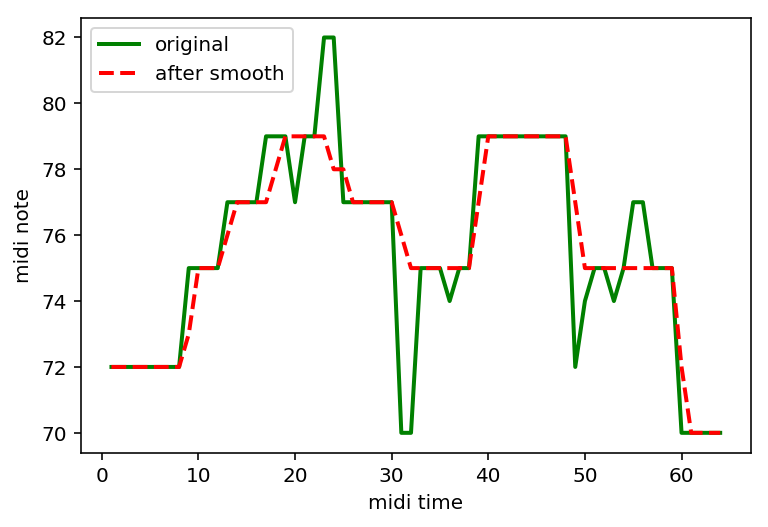

In [49]:
import matplotlib.pyplot as plt
plt.plot(x, y, color='green', linewidth=2, label='original')
plt.plot(x, y_s1, 'r--', linewidth=2, label='after smooth')
plt.xlabel('midi time')
plt.ylabel('midi note')
plt.legend(loc='upper left')
plt.savefig('result.png')